CUSTOMER SEGMENTATION


In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
import matplotlib.cm as cm
import itertools
import time
stime = time.time()

from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML
# import plotly.plotly as py
import plotly.graph_objs as go

from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline

## Research Methodology

In [3]:
df = pd.read_csv(
    "C:/Projects/E_Commerce_customer/resources/data.csv",
    dtype={'InvoiceNo': 'string', 'StockCode': 'string', 'Description': 'string', 'Country': 'string'},
    encoding="ISO-8859-1"
)
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12-01-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12-01-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12-01-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12-01-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12-01-2010 08:26,3.39,17850.0,United Kingdom


In [4]:
df.shape

(541909, 8)

In [5]:
df[df.InvoiceNo=="C536379"]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12-01-2010 09:41,27.5,14527.0,United Kingdom


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  string 
 1   StockCode    541909 non-null  string 
 2   Description  540455 non-null  string 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  string 
dtypes: float64(2), int64(1), object(1), string(4)
memory usage: 33.1+ MB


## Data Cleaning: Handle Missing Values

In [7]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [8]:
df[df['Description'].isnull()].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,<NA>,56,12-01-2010 11:52,0.0,NaN,United Kingdom
1970,536545,21134,<NA>,1,12-01-2010 14:32,0.0,NaN,United Kingdom
1971,536546,22145,<NA>,1,12-01-2010 14:33,0.0,NaN,United Kingdom
1972,536547,37509,<NA>,1,12-01-2010 14:33,0.0,NaN,United Kingdom
1987,536549,85226A,<NA>,1,12-01-2010 14:34,0.0,NaN,United Kingdom


In [9]:
df[df.StockCode=="22139"]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
106,536381,22139,RETROSPOT TEA SET CERAMIC 11 PC,23,12-01-2010 09:41,4.25,15311.0,United Kingdom
622,536414,22139,<NA>,56,12-01-2010 11:52,0.00,NaN,United Kingdom
6392,536942,22139,amazon,15,12-03-2010 12:08,0.00,NaN,United Kingdom
6885,536982,22139,RETROSPOT TEA SET CERAMIC 11 PC,10,12-03-2010 14:27,11.02,NaN,United Kingdom
7203,537011,22139,<NA>,-5,12-03-2010 15:38,0.00,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
538411,581405,22139,RETROSPOT TEA SET CERAMIC 11 PC,1,12-08-2011 13:50,4.95,13521.0,United Kingdom
539531,581439,22139,RETROSPOT TEA SET CERAMIC 11 PC,1,12-08-2011 16:30,10.79,NaN,United Kingdom
540441,581486,22139,RETROSPOT TEA SET CERAMIC 11 PC,6,12-09-2011 09:38,4.95,17001.0,United Kingdom
541387,581498,22139,RETROSPOT TEA SET CERAMIC 11 PC,2,12-09-2011 10:26,10.79,NaN,United Kingdom


In [10]:
df[df.StockCode=="22139"].Description.mode()


0    RETROSPOT TEA SET CERAMIC 11 PC 
Name: Description, dtype: string

In [11]:
most_freq = df[["StockCode","Description"]].value_counts().reset_index()
most_freq

,StockCode,Description,count
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,2302
1,22423,REGENCY CAKESTAND 3 TIER,2200
2,85099B,JUMBO BAG RED RETROSPOT,2159
3,47566,PARTY BUNTING,1727
4,20725,LUNCH BAG RED RETROSPOT,1638
...,...,...,...
4787,21491,SET OF THREE VINTAGE GIFT WRAPS,1
4788,84876D,damaged,1
4789,20827,damages,1
4790,20832,check,1


In [12]:
most_freq[most_freq.StockCode=="85123A"]

,StockCode,Description,count
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,2302
3320,85123A,CREAM HANGING HEART T-LIGHT HOLDER,9
4283,85123A,?,1
4284,85123A,wrongly marked carton 22804,1


In [13]:
most_freq[most_freq.StockCode=="85123A"]

,StockCode,Description,count
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,2302
3320,85123A,CREAM HANGING HEART T-LIGHT HOLDER,9
4283,85123A,?,1
4284,85123A,wrongly marked carton 22804,1


In [14]:
most_freq = most_freq.groupby("StockCode").head(1)
most_freq.head(5)

,StockCode,Description,count
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,2302
1,22423,REGENCY CAKESTAND 3 TIER,2200
2,85099B,JUMBO BAG RED RETROSPOT,2159
3,47566,PARTY BUNTING,1727
4,20725,LUNCH BAG RED RETROSPOT,1638


In [15]:
most_freq[most_freq.StockCode=="85123A"]

,StockCode,Description,count
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,2302


In [16]:
most_freq.columns = ["StockCode", "freq_Description", "count"]
most_freq.head(3)

,StockCode,freq_Description,count
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,2302
1,22423,REGENCY CAKESTAND 3 TIER,2200
2,85099B,JUMBO BAG RED RETROSPOT,2159


In [17]:
df1 = df.merge(most_freq, on="StockCode", how="left")
df1.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,freq_Description,count
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12-01-2010 08:26,2.55,17850.0,United Kingdom,WHITE HANGING HEART T-LIGHT HOLDER,2302.0
1,536365,71053,WHITE METAL LANTERN,6,12-01-2010 08:26,3.39,17850.0,United Kingdom,WHITE METAL LANTERN,328.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12-01-2010 08:26,2.75,17850.0,United Kingdom,CREAM CUPID HEARTS COAT HANGER,293.0


In [18]:
df1[df1['Description'].isnull()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,freq_Description,count
622,536414,22139,<NA>,56,12-01-2010 11:52,0.0,NaN,United Kingdom,RETROSPOT TEA SET CERAMIC 11 PC,988.0
1970,536545,21134,<NA>,1,12-01-2010 14:32,0.0,NaN,United Kingdom,<NA>,NaN
1971,536546,22145,<NA>,1,12-01-2010 14:33,0.0,NaN,United Kingdom,CHRISTMAS CRAFT HEART STOCKING,1.0
1972,536547,37509,<NA>,1,12-01-2010 14:33,0.0,NaN,United Kingdom,NEW ENGLAND MUG W GIFT BOX,2.0
1987,536549,85226A,<NA>,1,12-01-2010 14:34,0.0,NaN,United Kingdom,<NA>,NaN
...,...,...,...,...,...,...,...,...,...,...
535322,581199,84581,<NA>,-2,12-07-2011 18:26,0.0,NaN,United Kingdom,DOG TOY WITH PINK CROCHET SKIRT,91.0
535326,581203,23406,<NA>,15,12-07-2011 18:31,0.0,NaN,United Kingdom,HOME SWEET HOME KEY HOLDER,114.0
535332,581209,21620,<NA>,6,12-07-2011 18:35,0.0,NaN,United Kingdom,SET OF 4 ROSE BOTANICAL CANDLES,172.0
536981,581234,72817,<NA>,27,12-08-2011 10:33,0.0,NaN,United Kingdom,SET OF 2 CHRISTMAS DECOUPAGE CANDLE,164.0


In [19]:
df1['Description'] = df1['Description'].mask(df1['Description'].isnull(), df1['freq_Description'])
df1.isnull().sum()

InvoiceNo                0
StockCode                0
Description            112
Quantity                 0
InvoiceDate              0
UnitPrice                0
CustomerID          135080
Country                  0
freq_Description       112
count                  112
dtype: int64

In [20]:
df1.dropna(subset=['Description'],inplace=True)
df1.isnull().sum()

InvoiceNo                0
StockCode                0
Description              0
Quantity                 0
InvoiceDate              0
UnitPrice                0
CustomerID          134968
Country                  0
freq_Description         0
count                    0
dtype: int64

In [21]:
df1.drop(columns=["freq_Description","count"],inplace=True)

In [22]:
df1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12-01-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12-01-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12-01-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12-01-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12-01-2010 08:26,3.39,17850.0,United Kingdom


***lets assume its ok to have null value in CustomerID columns***

In [23]:
df1.describe()

,Quantity,UnitPrice,CustomerID
count,541797.000000,541797.000000,406829.000000
mean,9.555919,4.612067,15287.690570
std,218.103428,96.769831,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [24]:
df1[df1.Quantity<0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12-01-2010 09:41,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12-01-2010 09:49,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12-01-2010 10:24,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12-01-2010 10:24,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12-01-2010 10:24,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,12-09-2011 09:57,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,12-09-2011 10:28,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,12-09-2011 11:57,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,12-09-2011 11:58,1.25,17315.0,United Kingdom


In [25]:
df1[df1.UnitPrice<0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,08-12-2011 14:51,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,08-12-2011 14:52,-11062.06,NaN,United Kingdom


In [26]:
df2 = df1[(df1.UnitPrice>0) & (df1.Quantity>0)]
df2

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12-01-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12-01-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12-01-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12-01-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12-01-2010 08:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12-09-2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12-09-2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12-09-2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12-09-2011 12:50,4.15,12680.0,France


## Outliers

In [27]:
df2.describe()

,Quantity,UnitPrice,CustomerID
count,530104.000000,530104.000000,397884.000000
mean,10.542037,3.907625,15294.423453
std,155.524124,35.915681,1713.141560
min,1.000000,0.001000,12346.000000
25%,1.000000,1.250000,13969.000000
50%,3.000000,2.080000,15159.000000
75%,10.000000,4.130000,16795.000000
max,80995.000000,13541.330000,18287.000000


In [28]:
df2.Quantity.quantile(0.9999)

np.float64(1439.8763999990188)

In [29]:
df2[df2.Quantity>1500]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
4850,536809,84950,ASSORTED COLOUR T-LIGHT HOLDER,1824,12-02-2010 16:48,0.55,15299.0,United Kingdom
4945,536830,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,2880,12-02-2010 17:38,0.18,16754.0,United Kingdom
25920,538420,17096,ASSORTED LAQUERED INCENSE HOLDERS,1728,12-12-2010 12:03,0.17,12875.0,United Kingdom
32671,539101,22693,GROW A FLYTRAP OR SUNFLOWER IN TIN,2400,12-16-2010 10:35,0.94,16029.0,United Kingdom
52709,540815,85123A,WHITE HANGING HEART T-LIGHT HOLDER,1930,01-11-2011 12:55,2.55,15749.0,United Kingdom
52710,540815,21175,GIN + TONIC DIET METAL SIGN,2000,01-11-2011 12:55,1.85,15749.0,United Kingdom
52711,540815,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114,01-11-2011 12:55,2.10,15749.0,United Kingdom
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1-18-2011 10:01,1.04,12346.0,United Kingdom
80742,543057,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,2592,02-03-2011 10:50,0.21,16333.0,United Kingdom
87631,543669,22693,GROW A FLYTRAP OR SUNFLOWER IN TIN,2400,02-11-2011 11:22,0.94,16029.0,United Kingdom


In [30]:
mean = df2.Quantity.mean()
std = df2.Quantity.std()
mean, std

(np.float64(10.542037034242338), np.float64(155.52412351063626))

***lets assume huge quantity of order is legit*** ***lets not consider this a outlier***

## Feature Engineering

In [31]:
df3 = df2.copy()

df3['TotalSales']= df2['Quantity'] * df2['UnitPrice']
df3.describe()

,Quantity,UnitPrice,CustomerID,TotalSales
count,530104.000000,530104.000000,397884.000000,530104.000000
mean,10.542037,3.907625,15294.423453,20.121871
std,155.524124,35.915681,1713.141560,270.356743
min,1.000000,0.001000,12346.000000,0.001000
25%,1.000000,1.250000,13969.000000,3.750000
50%,3.000000,2.080000,15159.000000,9.900000
75%,10.000000,4.130000,16795.000000,17.700000
max,80995.000000,13541.330000,18287.000000,168469.600000


In [32]:
df3.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12-01-2010 08:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,12-01-2010 08:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12-01-2010 08:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12-01-2010 08:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12-01-2010 08:26,3.39,17850.0,United Kingdom,20.34


In [33]:
print(df3['InvoiceDate'].head(10))  # Check first 10 values


0    12-01-2010 08:26
1    12-01-2010 08:26
2    12-01-2010 08:26
3    12-01-2010 08:26
4    12-01-2010 08:26
5    12-01-2010 08:26
6    12-01-2010 08:26
7    12-01-2010 08:28
8    12-01-2010 08:28
9    12-01-2010 08:34
Name: InvoiceDate, dtype: object


In [34]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 530104 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    530104 non-null  string 
 1   StockCode    530104 non-null  string 
 2   Description  530104 non-null  string 
 3   Quantity     530104 non-null  int64  
 4   InvoiceDate  530104 non-null  object 
 5   UnitPrice    530104 non-null  float64
 6   CustomerID   397884 non-null  float64
 7   Country      530104 non-null  string 
 8   TotalSales   530104 non-null  float64
dtypes: float64(3), int64(1), object(1), string(4)
memory usage: 40.4+ MB


***as we can see INvoiceDate dtype is object which we need datetime dtype***

In [35]:
df3['InvoiceDate'] = pd.to_datetime(df3['InvoiceDate'])
df3.info()


<class 'pandas.core.frame.DataFrame'>
Index: 530104 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    530104 non-null  string        
 1   StockCode    530104 non-null  string        
 2   Description  530104 non-null  string        
 3   Quantity     530104 non-null  int64         
 4   InvoiceDate  530104 non-null  datetime64[ns]
 5   UnitPrice    530104 non-null  float64       
 6   CustomerID   397884 non-null  float64       
 7   Country      530104 non-null  string        
 8   TotalSales   530104 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), string(4)
memory usage: 40.4 MB


In [36]:
# Extract date (YYYY-MM-DD format)
df3['Month'] = df3['InvoiceDate'].dt.month
df3

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSales,Month
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,12
...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20,12
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60,12
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,12
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,12


In [37]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 530104 entries, 0 to 541908
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    530104 non-null  string        
 1   StockCode    530104 non-null  string        
 2   Description  530104 non-null  string        
 3   Quantity     530104 non-null  int64         
 4   InvoiceDate  530104 non-null  datetime64[ns]
 5   UnitPrice    530104 non-null  float64       
 6   CustomerID   397884 non-null  float64       
 7   Country      530104 non-null  string        
 8   TotalSales   530104 non-null  float64       
 9   Month        530104 non-null  int32         
dtypes: datetime64[ns](1), float64(3), int32(1), int64(1), string(4)
memory usage: 42.5 MB


## Visualization and EDA

In [38]:
monthly_sale = df3.groupby("Month")["TotalSales"].sum()
monthly_sale.tail(10)

Month
3      717639.360
4      537808.621
5      770536.020
6      761739.900
7      719221.191
8      759138.380
9     1058590.172
10    1154979.300
11    1509496.330
12    1462538.820
Name: TotalSales, dtype: float64

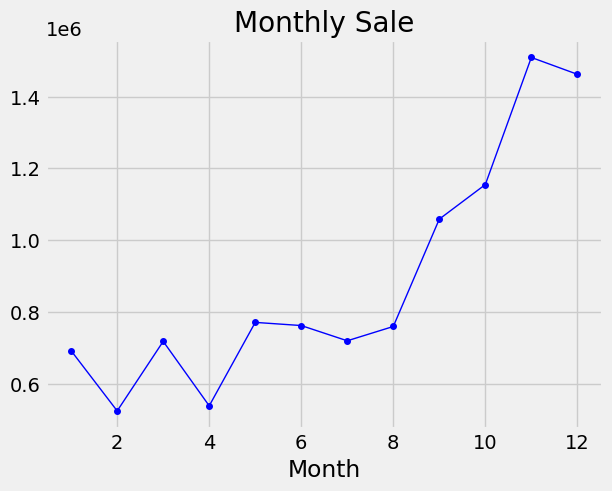

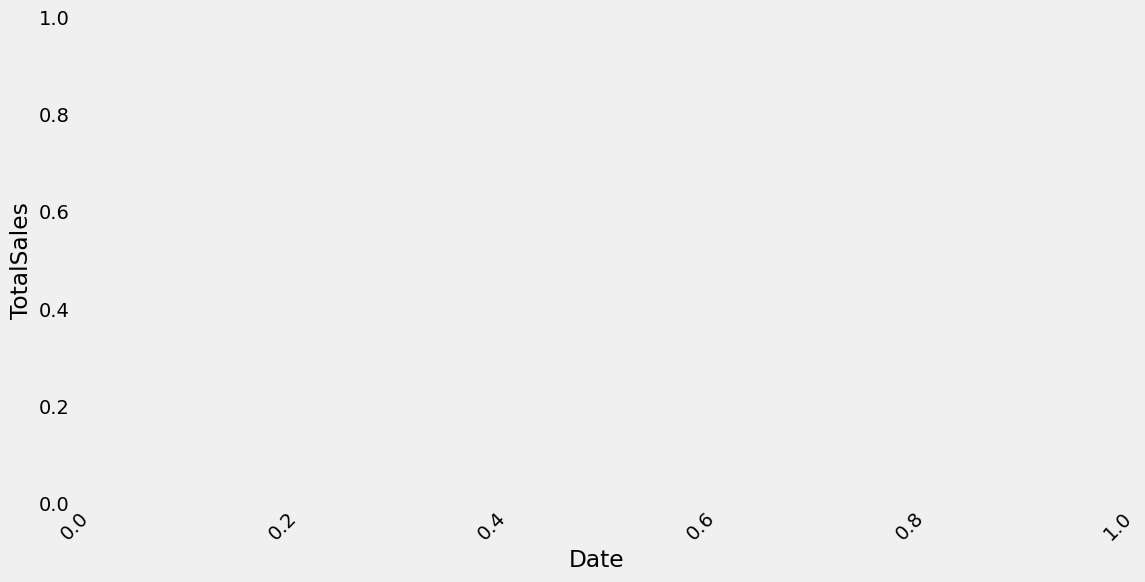

In [39]:
monthly_sale.plot(kind="line",title="Monthly Sale",marker="o",markersize=4, color="blue", linewidth=1)
plt.figure(figsize=(12, 6))
plt.xlabel("Date")
plt.ylabel("TotalSales")
plt.xticks(rotation=45)
plt.grid()
plt.show()

## Outlier

In [40]:
Q1 = df3["Quantity"].quantile(0.25)
Q3 = df3["Quantity"].quantile(0.75)
IQR = Q3 - Q1

# Define a reasonable range (1.5 * IQR is common)
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_filtered = df3[(df3["Quantity"] >= lower_bound) & (df3["Quantity"] <= upper_bound)]

df_filtered.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID,TotalSales,Month
count,473741.000000,473741,473741.000000,343411.000000,473741.000000,473741.000000
mean,4.716636,2011-07-04 13:21:12.163608320,4.216455,15335.251876,12.760273,7.569096
min,1.000000,2010-12-01 08:26:00,0.001000,12347.000000,0.001000,1.000000
25%,1.000000,2011-03-25 15:08:00,1.250000,14032.000000,3.300000,5.000000
50%,3.000000,2011-07-19 13:57:00,2.460000,15252.000000,8.280000,8.000000
75%,6.000000,2011-10-20 11:51:00,4.150000,16839.000000,16.500000,11.000000
max,23.000000,2011-12-09 12:50:00,13541.330000,18287.000000,13541.330000,12.000000
std,4.441115,NaN,37.965381,1707.135518,40.483825,3.522606


###after 8th month the sale is jumping #lets assume their might be huge discount over the products 
####wish could have more data to see the trend over a years###


## Countries

A quick look at the `respective countries` from which `orders` were made

In [41]:
temp_cou = df_filtered[['CustomerID', 'InvoiceNo', 'Country']].groupby(['CustomerID', 'InvoiceNo', 'Country']).count()
temp_cou

Empty DataFrame
Columns: []
Index: [(12347.0, 537626, Iceland), (12347.0, 542237, Iceland), (12347.0, 549222, Iceland), (12347.0, 556201, Iceland), (12347.0, 562032, Iceland), (12347.0, 573511, Iceland), (12347.0, 581180, Iceland), (12348.0, 539318, Finland), (12348.0, 541998, Finland), (12348.0, 548955, Finland), (12348.0, 568172, Finland), (12349.0, 577609, Italy), (12350.0, 543037, Norway), (12352.0, 544156, Norway), (12352.0, 545323, Norway), (12352.0, 545332, Norway), (12352.0, 546869, Norway), (12352.0, 547390, Norway), (12352.0, 567505, Norway), (12352.0, 568699, Norway), (12352.0, 574275, Norway), (12353.0, 553900, Bahrain), (12354.0, 550911, Spain), (12355.0, 552449, Bahrain), (12356.0, 541430, Portugal), (12356.0, 549435, Portugal), (12356.0, 576895, Portugal), (12357.0, 574740, Switzerland), (12358.0, 559707, Austria), (12358.0, 581232, Austria), (12359.0, 540946, Cyprus), (12359.0, 543370, Cyprus), (12359.0, 555477, Cyprus), (12359.0, 571034, Cyprus), (12360.0, 554132, Austria), (12360.0, 563749, Austria), (12360.0, 571705, Austria), (12361.0, 545017, Belgium), (12362.0, 544203, Belgium), (12362.0, 551346, Belgium), (12362.0, 559295, Belgium), (12362.0, 563037, Belgium), (12362.0, 568651, Belgium), (12362.0, 570667, Belgium), (12362.0, 572887, Belgium), (12362.0, 573173, Belgium), (12362.0, 574329, Belgium), (12362.0, 580979, Belgium), (12363.0, 549687, Unspecified), (12363.0, 563947, Unspecified), (12364.0, 563854, Belgium), (12364.0, 567897, Belgium), (12364.0, 573401, Belgium), (12364.0, 580152, Belgium), (12365.0, 544574, Cyprus), (12365.0, 544578, Cyprus), (12367.0, 580716, Denmark), (12370.0, 538826, Cyprus), (12370.0, 539330, Austria), (12370.0, 546236, Cyprus), (12370.0, 571905, Cyprus), (12371.0, 570521, Switzerland), (12371.0, 572770, Switzerland), (12372.0, 544157, Denmark), (12372.0, 552731, Denmark), (12372.0, 568872, Denmark), (12373.0, 542887, Austria), (12374.0, 576345, Austria), (12375.0, 565333, Finland), (12375.0, 579281, Finland), (12377.0, 539488, Switzerland), (12377.0, 542586, Switzerland), (12378.0, 562046, Switzerland), (12379.0, 557789, Belgium), (12379.0, 567196, Belgium), (12380.0, 555739, Belgium), (12380.0, 567928, Belgium), (12380.0, 571187, Belgium), (12380.0, 577180, Belgium), (12381.0, 563100, Norway), (12381.0, 570681, Norway), (12381.0, 570725, Norway), (12381.0, 574694, Norway), (12381.0, 580638, Norway), (12383.0, 539840, Belgium), (12383.0, 540971, Belgium), (12383.0, 546434, Belgium), (12383.0, 550284, Belgium), (12383.0, 555928, Belgium), (12384.0, 562882, Switzerland), (12384.0, 575734, Switzerland), (12386.0, 537676, Australia), (12388.0, 541271, Australia), (12388.0, 543357, Australia), (12388.0, 546135, Australia), (12388.0, 560033, Australia), (12388.0, 568145, Australia), (12388.0, 578459, Australia), (12390.0, 567530, Belgium), (12391.0, 577228, Cyprus), ...]

[16986 rows x 0 columns]

In [42]:
temp_cou = temp_cou.reset_index(drop = False)
temp_cou

,CustomerID,InvoiceNo,Country
0,12347.0,537626,Iceland
1,12347.0,542237,Iceland
2,12347.0,549222,Iceland
3,12347.0,556201,Iceland
4,12347.0,562032,Iceland
...,...,...,...
16981,18283.0,578262,United Kingdom
16982,18283.0,579673,United Kingdom
16983,18283.0,580872,United Kingdom
16984,18287.0,554065,United Kingdom


In [43]:
# Take count of the number of unique countries
countries = temp_cou['Country'].value_counts()
print('No. of countries in the dataframe: {}'.format(len(countries)))

No. of countries in the dataframe: 37


### Let's display the result on a chloropleth map

In [44]:
countries.index

Index(['United Kingdom', 'Germany', 'France', 'EIRE', 'Belgium', 'Spain',
       'Netherlands', 'Portugal', 'Switzerland', 'Australia', 'Finland',
       'Italy', 'Norway', 'Sweden', 'Channel Islands', 'Poland', 'Denmark',
       'Austria', 'Cyprus', 'Japan', 'Unspecified', 'Singapore', 'Iceland',
       'Greece', 'Israel', 'Canada', 'USA', 'European Community', 'Malta',
       'Lithuania', 'United Arab Emirates', 'Bahrain', 'Czech Republic', 'RSA',
       'Saudi Arabia', 'Lebanon', 'Brazil'],
      dtype='string', name='Country')

In [45]:
countries

Country
United Kingdom          15189
Germany                   453
France                    387
EIRE                      243
Belgium                    98
Spain                      84
Netherlands                76
Portugal                   56
Switzerland                50
Australia                  43
Finland                    41
Italy                      36
Norway                     36
Sweden                     29
Channel Islands            23
Poland                     19
Denmark                    17
Austria                    17
Cyprus                     14
Japan                      11
Unspecified                 8
Singapore                   7
Iceland                     7
Greece                      5
Israel                      5
Canada                      5
USA                         5
European Community          4
Malta                       4
Lithuania                   3
United Arab Emirates        3
Bahrain                     2
Czech Republic              2
RS

A `choropleth map` is a type of thematic map in which areas are shaded or patterned in proportion to a statistical variable that represents an aggregate summary of a geographic characteristic within each area, such as population density or per-capita income.

In [46]:
# Customize the data points
data = dict(type='choropleth', 
            locations = countries.index,
            locationmode = 'country names', z = countries,
            text = countries.index, colorbar = {'title':'Order no.'},
            colorscale=[[0, 'rgb(224,255,255)'],
            [0.01, 'rgb(166,206,227)'], [0.02, 'rgb(31,120,180)'],
            [0.03, 'rgb(178,223,138)'], [0.05, 'rgb(51,160,44)'],
            [0.10, 'rgb(251,154,153)'], [0.20, 'rgb(255,255,0)'],
            [1, 'rgb(227,26,28)']],    
            reversescale = False)

In [47]:


layout = dict(title='Number of orders per country',
              geo = dict(showframe = True, projection={'type':'mercator'}))

choromap = go.Figure(data = [data], layout = layout)
iplot(choromap, validate=False)

### Top 5 countries for Total Sales

In [48]:
top_5_countries = df_filtered.groupby('Country')["TotalSales"].sum().sort_values(ascending=False).head(5).round()
top_5_countries

Country
United Kingdom    5265439.0
Germany            161909.0
France             145619.0
EIRE               140648.0
Spain               39314.0
Name: TotalSales, dtype: float64

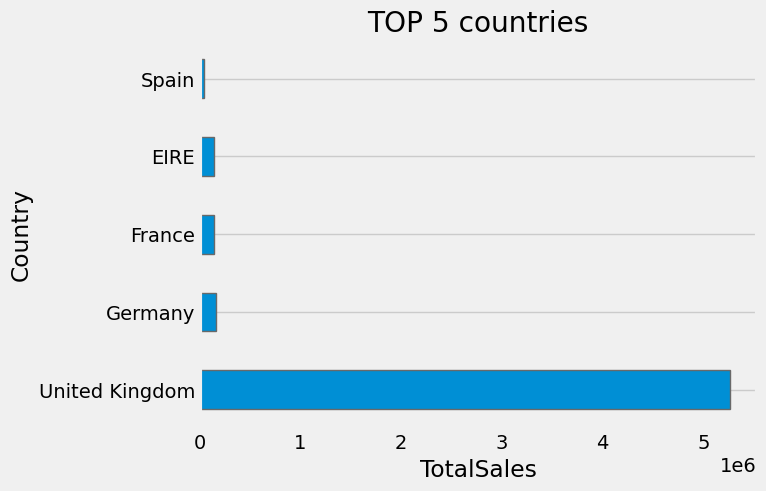

In [49]:
top_5_countries.plot(kind='barh',title="TOP 5 countries")
plt.xlabel('TotalSales')
plt.ylabel('Country')
plt.grid(axis='x')
plt.show()

*** lets plot by percentage wise***


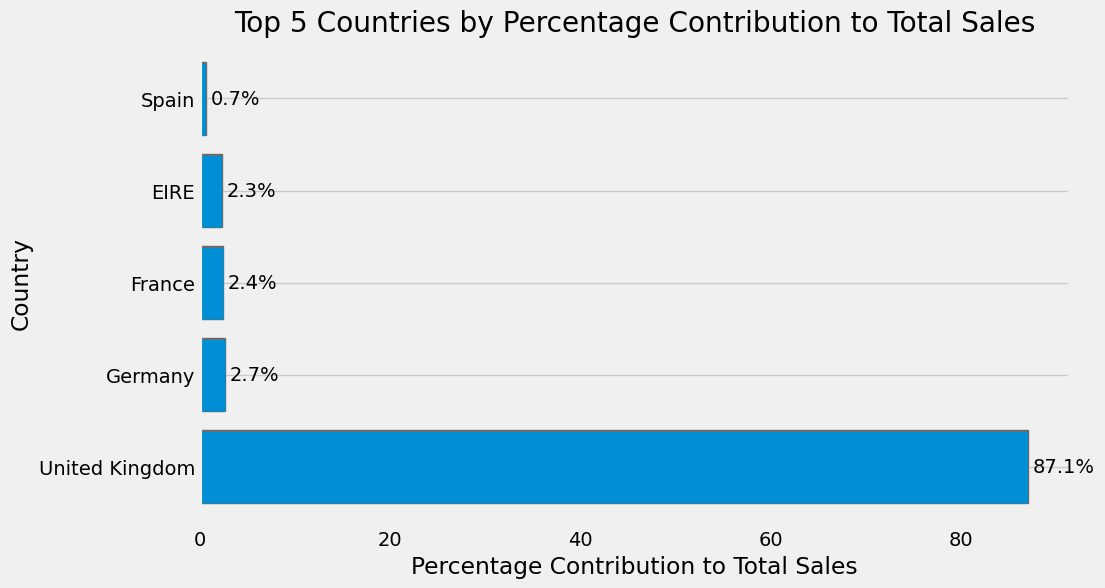

In [50]:

country_wise_sales = df_filtered.groupby('Country')['TotalSales'].sum()
total_sales = country_wise_sales.sum()

top_5_countries = country_wise_sales.sort_values(ascending=False).head(5)
per_cont = (top_5_countries / total_sales) * 100

plt.figure(figsize=(10, 6))
bars = plt.barh(top_5_countries.index, per_cont)
plt.xlabel('Percentage Contribution to Total Sales')
plt.ylabel('Country')
plt.title('Top 5 Countries by Percentage Contribution to Total Sales')
plt.grid(axis='x')

# Add percentage labels to the bars
for bar, percentage in zip(bars, per_cont):
    plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, f'{percentage:.1f}%', va='center')

plt.show()


In [51]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 473741 entries, 0 to 541908
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    473741 non-null  string        
 1   StockCode    473741 non-null  string        
 2   Description  473741 non-null  string        
 3   Quantity     473741 non-null  int64         
 4   InvoiceDate  473741 non-null  datetime64[ns]
 5   UnitPrice    473741 non-null  float64       
 6   CustomerID   343411 non-null  float64       
 7   Country      473741 non-null  string        
 8   TotalSales   473741 non-null  float64       
 9   Month        473741 non-null  int32         
dtypes: datetime64[ns](1), float64(3), int32(1), int64(1), string(4)
memory usage: 38.0 MB


## lets see product wise sales

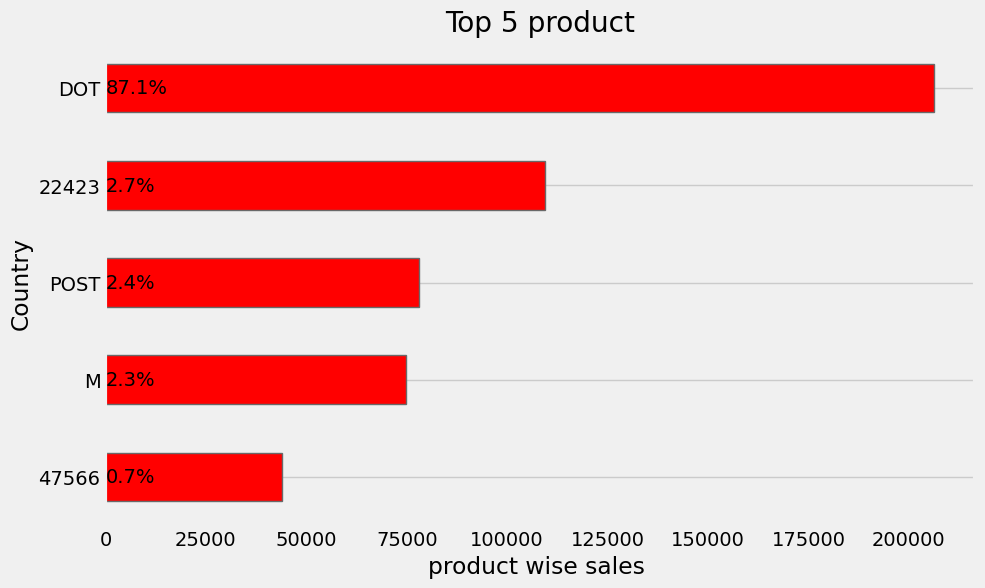

In [52]:
product_wise_sales = df_filtered.groupby('StockCode')['TotalSales'].sum()


top_5_product = product_wise_sales.sort_values(ascending=False).head(5)


plt.figure(figsize=(10, 6))
top_5_product.plot(kind="barh",color = 'Red')
plt.xlabel('product wise sales ')

product_wise_sales = df_filtered.groupby('StockCode')['TotalSales'].sum()
plt.ylabel('Country')
plt.title('Top 5 product')
plt.gca().invert_yaxis()
plt.grid(axis='x')

# Add percentage labels to the bars
for bar, percentage in zip(bars, per_cont):
    plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, f'{percentage:.1f}%', va='center')

plt.show()


In [53]:
df_filtered[df_filtered.StockCode=='DOT']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSales,Month
1814,536544,DOT,DOTCOM POSTAGE,1,2010-12-01 14:32:00,569.77,NaN,United Kingdom,569.77,12
3041,536592,DOT,DOTCOM POSTAGE,1,2010-12-01 17:06:00,607.49,NaN,United Kingdom,607.49,12
5450,536862,DOT,DOTCOM POSTAGE,1,2010-12-03 11:13:00,254.43,NaN,United Kingdom,254.43,12
5545,536864,DOT,DOTCOM POSTAGE,1,2010-12-03 11:27:00,121.06,NaN,United Kingdom,121.06,12
5685,536865,DOT,DOTCOM POSTAGE,1,2010-12-03 11:28:00,498.47,NaN,United Kingdom,498.47,12
...,...,...,...,...,...,...,...,...,...,...
536834,581219,DOT,DOTCOM POSTAGE,1,2011-12-08 09:28:00,1008.96,NaN,United Kingdom,1008.96,12
537254,581238,DOT,DOTCOM POSTAGE,1,2011-12-08 10:53:00,1683.75,NaN,United Kingdom,1683.75,12
539368,581439,DOT,DOTCOM POSTAGE,1,2011-12-08 16:30:00,938.59,NaN,United Kingdom,938.59,12
540908,581492,DOT,DOTCOM POSTAGE,1,2011-12-09 10:03:00,933.17,NaN,United Kingdom,933.17,12


#lets print those top 5 products#

In [54]:
for stock_code in top_5_product.index:
    Description	=df_filtered[df_filtered.StockCode==stock_code].Description.iloc[0]
    print(f"{stock_code} ==>{Description}")

DOT ==>DOTCOM POSTAGE
22423 ==>REGENCY CAKESTAND 3 TIER
POST ==>POSTAGE
M ==>Manual
47566 ==>PARTY BUNTING


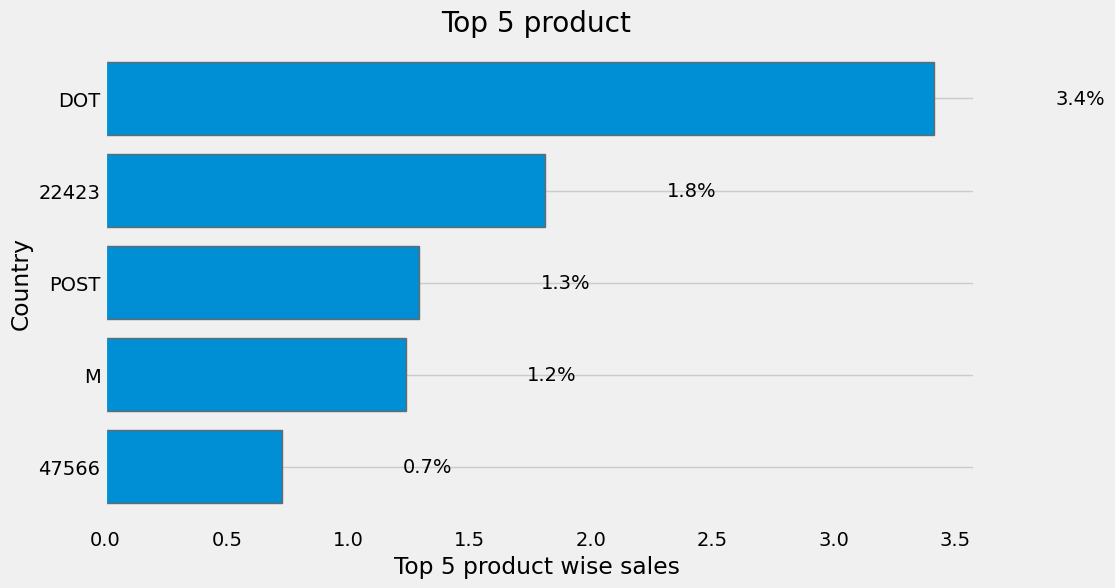

In [55]:
total_sales = product_wise_sales.sum()
percentage = (top_5_product / total_sales) * 100

plt.figure(figsize=(10, 6))
bars = plt.barh(top_5_product.index,percentage)

plt.xlabel('Top 5 product wise sales ')

plt.ylabel('Country')
plt.title('Top 5 product ')
plt.gca().invert_yaxis()
plt.grid(axis='x')

# Add percentage labels to the bars
for bar, percentage in zip(bars, percentage):
    plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, f'{percentage:.1f}%', va='center')

plt.show()


# **RFM ANALYSIS**

In [56]:
current_date = df_filtered['InvoiceDate'].max() + pd.Timedelta(days=1)
current_date

Timestamp('2011-12-10 12:50:00')

In [57]:
rfm = df_filtered.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (current_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalSales': 'sum'

})

rfm.columns = ['Recency','Frequency','Monetary']
rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12347.0,2,147,3097.82
12348.0,75,5,377.00
12349.0,19,68,1626.15
12350.0,310,16,314.00
12352.0,36,85,2506.04


In [58]:
df_filtered[df_filtered.CustomerID==12347]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSales,Month
14938,537626,85116,BLACK CANDELABRA T-LIGHT HOLDER,12,2010-12-07 14:57:00,2.10,12347.0,Iceland,25.20,12
14939,537626,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2010-12-07 14:57:00,4.25,12347.0,Iceland,17.00,12
14940,537626,71477,COLOUR GLASS. STAR T-LIGHT HOLDER,12,2010-12-07 14:57:00,3.25,12347.0,Iceland,39.00,12
14942,537626,22771,CLEAR DRAWER KNOB ACRYLIC EDWARDIAN,12,2010-12-07 14:57:00,1.25,12347.0,Iceland,15.00,12
14943,537626,22772,PINK DRAWER KNOB ACRYLIC EDWARDIAN,12,2010-12-07 14:57:00,1.25,12347.0,Iceland,15.00,12
...,...,...,...,...,...,...,...,...,...,...
535010,581180,20719,WOODLAND CHARLOTTE BAG,10,2011-12-07 15:52:00,0.85,12347.0,Iceland,8.50,12
535011,581180,21265,PINK GOOSE FEATHER TREE 60CM,12,2011-12-07 15:52:00,1.95,12347.0,Iceland,23.40,12
535012,581180,23271,CHRISTMAS TABLE SILVER CANDLE SPIKE,16,2011-12-07 15:52:00,0.83,12347.0,Iceland,13.28,12
535013,581180,23506,MINI PLAYING CARDS SPACEBOY,20,2011-12-07 15:52:00,0.42,12347.0,Iceland,8.40,12


In [59]:
df_filtered[df_filtered.CustomerID==12347]['TotalSales'].sum()

#checking if the agg function is working correctly


np.float64(3097.82)

In [60]:
rfm.describe()

,Recency,Frequency,Monetary
count,4216.000000,4216.000000,4216.000000
mean,93.082543,81.454222,1097.402890
std,100.129123,212.551778,2511.030355
min,1.000000,1.000000,1.900000
25%,18.000000,14.000000,222.715000
50%,51.000000,36.000000,508.425000
75%,145.000000,88.000000,1179.850000
max,374.000000,7694.000000,98916.420000


In [61]:
# Segment Customers based on RFM
rfm['R_Segment'] = pd.qcut(rfm['Recency'], 4, labels=[4, 3, 2, 1])
rfm['F_Segment'] = pd.qcut(rfm['Frequency'], 4, labels=[1, 2, 3, 4])
rfm['M_Segment'] = pd.qcut(rfm['Monetary'], 4, labels=[1, 2, 3, 4])
rfm['RFM_Score'] = rfm[['R_Segment', 'F_Segment', 'M_Segment']].sum(axis=1)

In [62]:
rfm.sample(5)

,Recency,Frequency,Monetary,R_Segment,F_Segment,M_Segment,RFM_Score
CustomerID,,,,,,,
16009.0,22,88,919.75,3,3,3,9
15773.0,6,6,97.90,4,1,1,6
13079.0,22,5,190.10,3,1,1,5
13194.0,136,3,60.70,2,1,1,4
16943.0,212,33,816.73,1,2,3,6


In [63]:
# Customers with highest RFM Scores
rfm.sort_values('RFM_Score', ascending=False)   # higher the RFM score the Best Customers

,Recency,Frequency,Monetary,R_Segment,F_Segment,M_Segment,RFM_Score
CustomerID,,,,,,,
12347.0,2,147,3097.82,4,4,4,12
15804.0,1,228,3828.87,4,4,4,12
18283.0,4,756,2094.88,4,4,4,12
18245.0,7,157,2338.46,4,4,4,12
18241.0,10,89,1843.65,4,4,4,12
...,...,...,...,...,...,...,...
16055.0,221,8,134.80,1,1,1,3
13216.0,268,1,10.50,1,1,1,3
13161.0,313,8,112.75,1,1,1,3


In [64]:
rfm.describe()

,Recency,Frequency,Monetary,RFM_Score
count,4216.000000,4216.000000,4216.000000,4216.000000
mean,93.082543,81.454222,1097.402890,7.498102
std,100.129123,212.551778,2511.030355,2.829601
min,1.000000,1.000000,1.900000,3.000000
25%,18.000000,14.000000,222.715000,5.000000
50%,51.000000,36.000000,508.425000,7.000000
75%,145.000000,88.000000,1179.850000,10.000000
max,374.000000,7694.000000,98916.420000,12.000000


In [65]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])
rfm_scaled

array([[-0.90975876,  0.30841216,  0.7967464 ],
       [-0.18061366, -0.3597396 , -0.28692936],
       [-0.73995784, -0.06330607,  0.21059476],
       ...,
       [-0.84982902, -0.33150783, -0.37171338],
       [-0.88978218,  3.17393623,  0.39728529],
       [-0.34042628, -0.22799136, -0.19592803]], shape=(4216, 3))

In [66]:
# Convert the scaled array back into a DataFrame
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'])

In [67]:
rfm_scaled_df.describe()

,Recency,Frequency,Monetary
count,4.216000e+03,4.216000e+03,4.216000e+03
mean,5.751250e-17,9.269414e-18,4.718975e-17
std,1.000119e+00,1.000119e+00,1.000119e+00
min,-9.197470e-01,-3.785608e-01,-4.363280e-01
25%,-7.499461e-01,-3.173919e-01,-3.483796e-01
50%,-4.203326e-01,-2.138755e-01,-2.345841e-01
75%,5.185666e-01,3.079981e-02,3.283787e-02
max,2.805885e+00,3.581927e+01,3.896035e+01


## Model Selection:

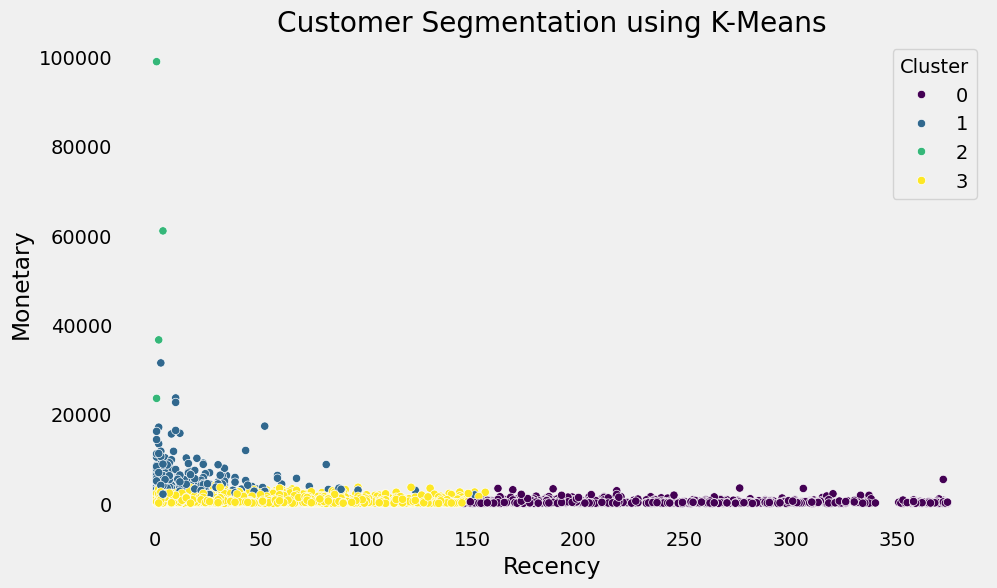

In [68]:
# Clustering - K-Means

kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster_KMeans'] = kmeans.fit_predict(rfm_scaled_df)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=rfm['Recency'], y=rfm['Monetary'], hue=rfm['Cluster_KMeans'], palette='viridis')
plt.title("Customer Segmentation using K-Means")
plt.xlabel("Recency")
plt.ylabel("Monetary")  
plt.legend(title="Cluster")
plt.grid()
plt.show()

# Elbow Method to find optimal number of clusters

## NOTE :
From the scatter plot:

Cluster 0 (Purple): Customers with low recency and moderate monetary values.

Cluster 1 (Blue): Customers with moderate recency and low monetary value.

Cluster 2 (Green): High-spending customers with recent purchases.

Cluster 3 (Yellow): Customers with high recency (haven't purchased recently).

In [69]:
centroid = kmeans.cluster_centers_
centroid

array([[ 1.55830034, -0.26455136, -0.29721388],
       [-0.77642974,  1.46799893,  1.67252039],
       [-0.90975876, 25.13589621, 21.4800377 ],
       [-0.48048538, -0.09642372, -0.10138824]])

Text(0.5, 1.0, 'Customer Segmentation using K-Means with Centroids')

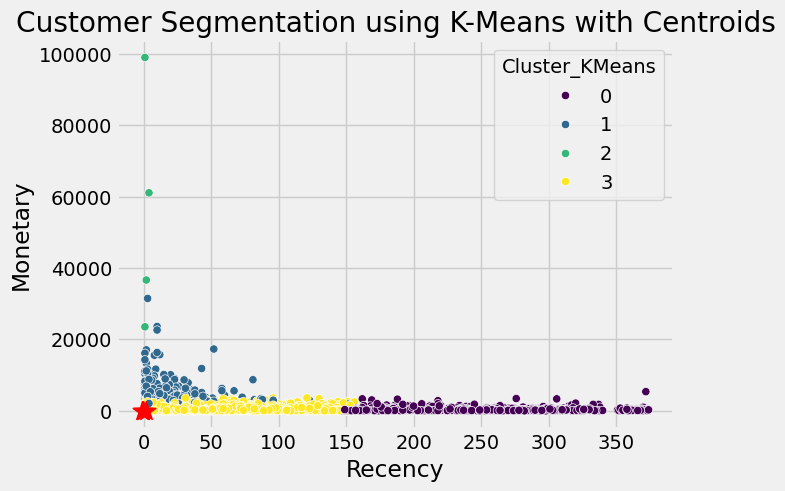

In [70]:
sns.scatterplot(x=rfm['Recency'], y=rfm['Monetary'], hue=rfm['Cluster_KMeans'], palette='viridis')
plt.scatter(centroid[:, 0], centroid[:, 2], s=200, c='red', marker='*', label='Centroids')
plt.title("Customer Segmentation using K-Means with Centroids")

#some of square error

In [71]:
sse = [] 
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k,n_init='auto', random_state=42)
    kmeans.fit(rfm_scaled_df)
    sse.append(kmeans.inertia_)
sse

[12648.000000000002,
 9074.47430178845,
 4731.666847498023,
 3161.1412848517466,
 2641.966663044225,
 2214.3417525243694,
 1789.2408943714743,
 1555.5740353633507,
 1414.3018914085928,
 1245.7566967734626]

** ELBOW method

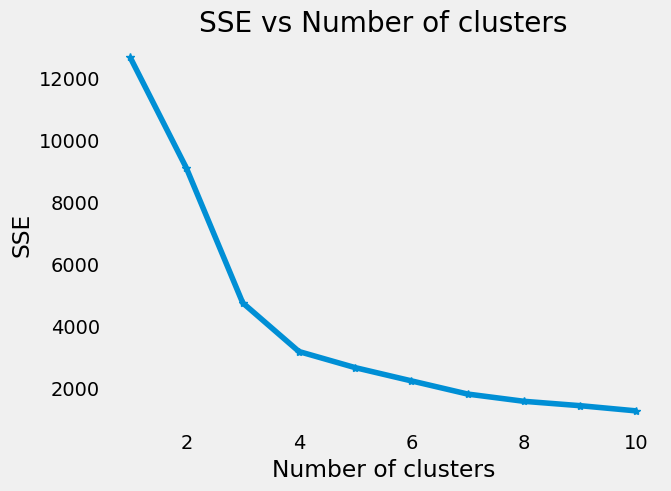

In [72]:
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.plot(range(1, 11), sse, marker='*')
plt.title('SSE vs Number of clusters') 
plt.grid()
plt.show()

 Hierarchical Clustering
We apply Agglomerative Clustering with Ward linkage.

In [73]:
rfm_scaled_df

,Recency,Frequency,Monetary
0,-0.909759,0.308412,0.796746
1,-0.180614,-0.359740,-0.286929
2,-0.739958,-0.063306,0.210595
3,2.166634,-0.307981,-0.312022
4,-0.570157,0.016684,0.561046
...,...,...,...
4211,1.847009,-0.336213,-0.365154
4212,0.878145,-0.350329,-0.404895
4213,-0.849829,-0.331508,-0.371713
4214,-0.889782,3.173936,0.397285


## Hierarchical Cluster

In [74]:
from sklearn.cluster import AgglomerativeClustering

hc = AgglomerativeClustering(n_clusters=3,metric="euclidean", linkage='average')
hc.fit_predict(rfm_scaled_df[["Recency", "Monetary"]])

rfm['Hierarchical_Cluster'] = hc.labels_


In [75]:
hc

AgglomerativeClustering(linkage='average', n_clusters=3)

In [76]:
hc.labels_

array([0, 0, 0, ..., 0, 0, 0], shape=(4216,))

In [77]:
rfm_scaled_df['Cluster'] = hc.labels_
rfm_scaled_df

,Recency,Frequency,Monetary,Cluster
0,-0.909759,0.308412,0.796746,0
1,-0.180614,-0.359740,-0.286929,0
2,-0.739958,-0.063306,0.210595,0
3,2.166634,-0.307981,-0.312022,0
4,-0.570157,0.016684,0.561046,0
...,...,...,...,...
4211,1.847009,-0.336213,-0.365154,0
4212,0.878145,-0.350329,-0.404895,0
4213,-0.849829,-0.331508,-0.371713,0
4214,-0.889782,3.173936,0.397285,0


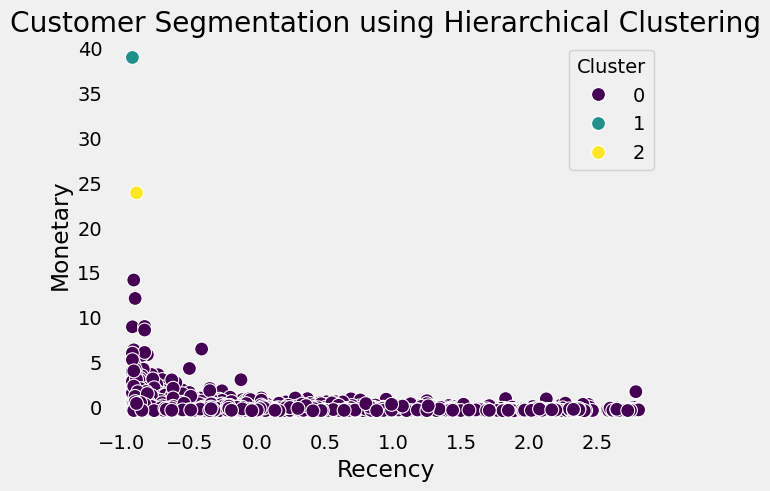

In [78]:
sns.scatterplot(x=rfm_scaled_df['Recency'], y=rfm_scaled_df['Monetary'],s=100, hue=rfm_scaled_df['Cluster'], palette='viridis')
plt.title("Customer Segmentation using Hierarchical Clustering")
plt.xlabel("Recency")
plt.ylabel("Monetary")
plt.legend(title="Cluster")
plt.grid()
plt.show()

** ## Cluster Distribution:

Cluster 0 (Purple): The majority of customers belong to this cluster. They tend to have low monetary values and a wide range of recency values.

Cluster 1 (Teal): A very small number of customers belong to this cluster, with extremely high monetary values. These could be high-value customers who make large purchases.

Cluster 2 (Yellow): Another small cluster with relatively high monetary values but different recency characteristics.

###Possible Business Actions:
Retain High-Value Customers (Clusters 1 & 2): Provide exclusive deals, loyalty programs, or personalized marketing to keep them engaged.

Engage Low-Spending Customers (Cluster 0): Offer incentives or promotional discounts to encourage higher spending and repeat purchases.

Further Segment Analysis: Investigate additional factors such as frequency, customer demographics, or purchasing history to refine marketing efforts.

## ploting dendrogram

In [79]:
from scipy.cluster.hierarchy import dendrogram, linkage,fcluster

x = rfm_scaled_df[["Recency", "Monetary"]]
z = linkage(x, method='average')
z

array([[1.20000000e+02, 3.74900000e+03, 0.00000000e+00, 2.00000000e+00],
       [3.61100000e+03, 3.67200000e+03, 0.00000000e+00, 2.00000000e+00],
       [9.59000000e+02, 2.00800000e+03, 0.00000000e+00, 2.00000000e+00],
       ...,
       [8.42600000e+03, 8.42700000e+03, 1.06593773e+01, 4.21400000e+03],
       [1.25900000e+03, 1.83300000e+03, 1.50899365e+01, 2.00000000e+00],
       [8.42800000e+03, 8.42900000e+03, 3.14605498e+01, 4.21600000e+03]],
      shape=(4215, 4))

we perform **Hierarchical Clustering** to segment **top 10 customers' based on their** **Recency, Frequency, and Monetary (RFM) values**.


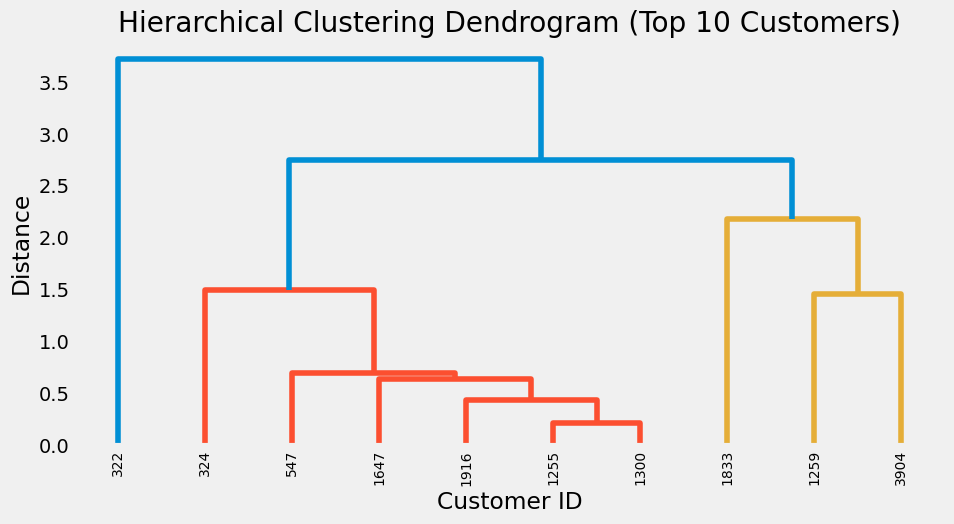

In [80]:
# Select top 10 customers based on Monetary value
top_10_customers = rfm_scaled_df.nlargest(10, "Monetary")

# Scale the data (if not already done)

rfm_scaled_top10 = scaler.fit_transform(top_10_customers[['Recency', 'Frequency', 'Monetary']])

# Perform hierarchical clustering
from scipy.cluster.hierarchy import linkage, dendrogram
z_top10 = linkage(rfm_scaled_top10, method="average")

# Plot the dendrogram
plt.figure(figsize=(10, 5))
plt.title("Hierarchical Clustering Dendrogram (Top 10 Customers)")
dendrogram(z_top10, labels=top_10_customers.index, leaf_rotation=90, leaf_font_size=10)
plt.xlabel("Customer ID")
plt.ylabel("Distance")
plt.grid()
plt.show()


** ## Key Observations:

1 .Cluster Formation:

The dendrogram shows how individual customers are merged into clusters step by step.

At the lower levels, customers are first grouped into small clusters.

These smaller clusters then merge into larger clusters as we move up.

2 .Distance Between Clusters:

The vertical height of the connections (linkage distance) indicates how different the clusters/customers are.

Shorter connections (lower heights) represent more similar customers.

Longer connections (higher distances) indicate that those customers are more distinct and were merged at a later stage.

3 .Color-coded Clusters:

Three main clusters are identifiable in different colors (Red, Orange, and Blue).

The Red cluster consists of customers with high similarity.

The Orange cluster merges at a higher level, meaning customers in this group are somewhat different from each other.

The Blue cluster merges at the highest level, meaning those customers are very different from the others.

4 .Business Implications:

Customers in the same cluster likely exhibit similar purchasing behaviors and should be targeted with similar marketing strategies.

Distant clusters (Blue group) indicate customers with very different purchasing patterns, which might require customized engagement strategies.

## DBSCAN

In [81]:
from sklearn.cluster import DBSCAN

# Apply DBSCAN
dbscan = DBSCAN(eps=0.3, min_samples=10)  # Adjust parameters as needed
rfm["DBSCAN_Cluster"] = dbscan.fit_predict(rfm_scaled_df)

# Count cluster labels
print(rfm["DBSCAN_Cluster"].value_counts())




DBSCAN_Cluster
 0    4076
-1     140
Name: count, dtype: int64


In [82]:
outliers = rfm[rfm["DBSCAN_Cluster"] == -1]

# Display the first few outliers
print(outliers.head())


            Recency  Frequency  Monetary R_Segment F_Segment M_Segment  \
CustomerID                                                               
12359.0          58        242   6284.62         2         4         4   
12378.0         130        193   3423.68         2         4         4   
12428.0          26        239   6892.54         3         4         4   
12471.0           2        320   9818.35         4         4         4   
12477.0          23        265   9051.82         3         4         4   

            RFM_Score  Cluster_KMeans  Hierarchical_Cluster  DBSCAN_Cluster  
CustomerID                                                                   
12359.0            10               1                     0              -1  
12378.0            10               3                     0              -1  
12428.0            11               1                     0              -1  
12471.0            12               1                     0              -1  
12477.0      

** ploting to check for outlier

These customers have RFM scores of 10, 11, or 12, which indicate they are likely valuable customers.

High Frequency & Monetary values suggest they are frequent, high-spending customers

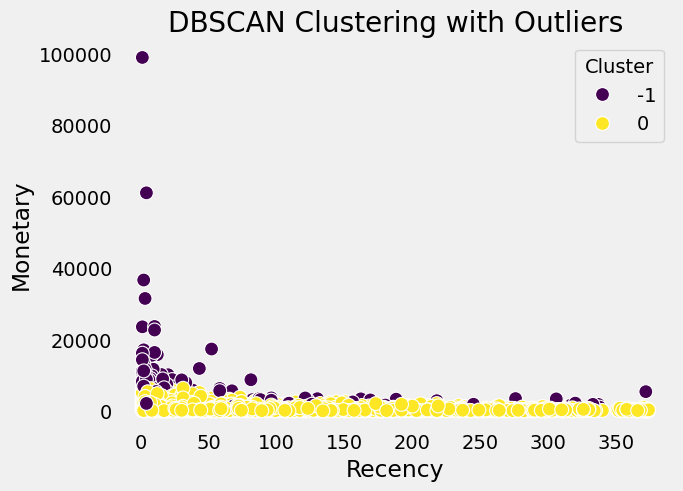

In [83]:
sns.scatterplot(x=rfm["Recency"], y=rfm["Monetary"], hue=rfm["DBSCAN_Cluster"], palette="viridis", s=100)
plt.title("DBSCAN Clustering with Outliers")
plt.xlabel("Recency")
plt.ylabel("Monetary")
plt.legend(title="Cluster")
plt.grid()
plt.show()



In [84]:
rfm

,Recency,Frequency,Monetary,R_Segment,F_Segment,M_Segment,RFM_Score,Cluster_KMeans,Hierarchical_Cluster,DBSCAN_Cluster
CustomerID,,,,,,,,,,
12347.0,2,147,3097.82,4,4,4,12,3,0,0
12348.0,75,5,377.00,2,1,2,5,3,0,0
12349.0,19,68,1626.15,3,3,4,10,3,0,0
12350.0,310,16,314.00,1,2,2,5,0,0,0
12352.0,36,85,2506.04,3,3,4,10,3,0,0
...,...,...,...,...,...,...,...,...,...,...
18280.0,278,10,180.60,1,1,1,3,0,0,0
18281.0,181,7,80.82,1,1,1,3,0,0,0
18282.0,8,11,164.13,4,1,1,6,3,0,0


In [85]:
rfm_scaled_df

,Recency,Frequency,Monetary,Cluster
0,-0.909759,0.308412,0.796746,0
1,-0.180614,-0.359740,-0.286929,0
2,-0.739958,-0.063306,0.210595,0
3,2.166634,-0.307981,-0.312022,0
4,-0.570157,0.016684,0.561046,0
...,...,...,...,...
4211,1.847009,-0.336213,-0.365154,0
4212,0.878145,-0.350329,-0.404895,0
4213,-0.849829,-0.331508,-0.371713,0
4214,-0.889782,3.173936,0.397285,0


In [86]:
# Compute Silhouette Scores
kmeans_silhouette = silhouette_score(rfm_scaled_df.drop(columns=["Cluster"]), rfm["Cluster_KMeans"])
hierarchical_silhouette = silhouette_score(rfm_scaled_df.drop(columns=["Cluster"]), rfm["Hierarchical_Cluster"])
dbscan_silhouette = silhouette_score(rfm_scaled_df.drop(columns=["Cluster"]), rfm["DBSCAN_Cluster"]) if len(set(rfm["DBSCAN_Cluster"])) > 1 else -1

# Print Comparison
print(f"Silhouette Score - K-Means: {kmeans_silhouette}")
print(f"Silhouette Score - Hierarchical: {hierarchical_silhouette}")
print(f"Silhouette Score - DBSCAN: {dbscan_silhouette}")


Silhouette Score - K-Means: 0.5921892969045092
Silhouette Score - Hierarchical: 0.9539510632603526
Silhouette Score - DBSCAN: 0.6830428361145234


6. Key Insights
Based on the segmentation, we identify three main customer groups:

High-Value Customers

Frequent buyers with high spending.

Strategy: Loyalty programs, exclusive offers, premium services.

Occasional Buyers

Buy moderately but not frequently.

Strategy: Personalized discounts, upselling/cross-selling.

Churned or Inactive Customers

Haven’t purchased in a long time.

Strategy: Win-back campaigns, re-engagement offers.

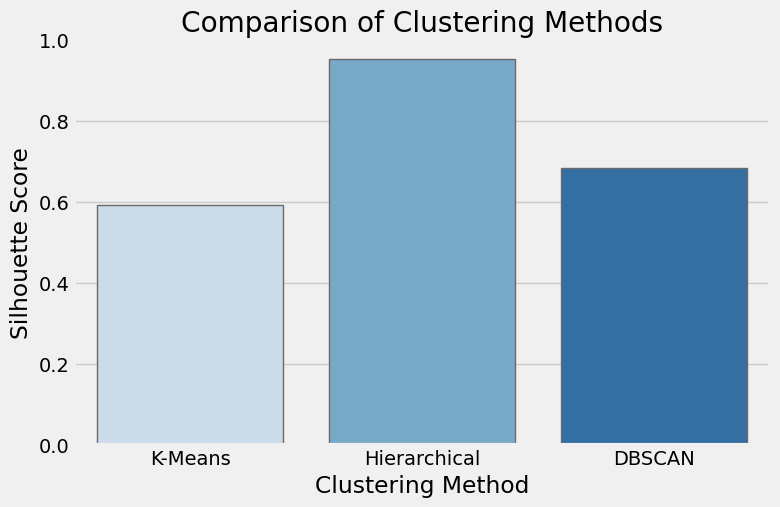

In [87]:
# Visualization
palette = sns.color_palette("husl", 3)

plt.figure(figsize=(8, 5))
methods = ["K-Means", "Hierarchical", "DBSCAN"]
scores = [kmeans_silhouette, hierarchical_silhouette, dbscan_silhouette]
sns.barplot(x=methods, y=scores, palette="Blues")
plt.xlabel("Clustering Method")
plt.ylabel("Silhouette Score")
plt.title("Comparison of Clustering Methods")
plt.show()


## Customer Churn

In [88]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 473741 entries, 0 to 541908
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    473741 non-null  string        
 1   StockCode    473741 non-null  string        
 2   Description  473741 non-null  string        
 3   Quantity     473741 non-null  int64         
 4   InvoiceDate  473741 non-null  datetime64[ns]
 5   UnitPrice    473741 non-null  float64       
 6   CustomerID   343411 non-null  float64       
 7   Country      473741 non-null  string        
 8   TotalSales   473741 non-null  float64       
 9   Month        473741 non-null  int32         
dtypes: datetime64[ns](1), float64(3), int32(1), int64(1), string(4)
memory usage: 38.0 MB


In [89]:
customer_last_purchase = df_filtered.groupby('CustomerID')['InvoiceDate'].max()
customer_last_purchase

CustomerID
12347.0   2011-12-07 15:52:00
12348.0   2011-09-25 13:13:00
12349.0   2011-11-21 09:51:00
12350.0   2011-02-02 16:01:00
12352.0   2011-11-03 14:37:00
                  ...        
18280.0   2011-03-07 09:52:00
18281.0   2011-06-12 10:53:00
18282.0   2011-12-02 11:43:00
18283.0   2011-12-06 12:02:00
18287.0   2011-10-12 10:23:00
Name: InvoiceDate, Length: 4216, dtype: datetime64[ns]

In [90]:
customer_last_purchase = (current_date - customer_last_purchase).dt.days
customer_last_purchase

CustomerID
12347.0      2
12348.0     75
12349.0     19
12350.0    310
12352.0     36
          ... 
18280.0    278
18281.0    181
18282.0      8
18283.0      4
18287.0     59
Name: InvoiceDate, Length: 4216, dtype: int64

In [91]:
churn_threshold = 90 
churned = customer_last_purchase > churn_threshold
churned

CustomerID
12347.0    False
12348.0    False
12349.0    False
12350.0     True
12352.0    False
           ...  
18280.0     True
18281.0     True
18282.0    False
18283.0    False
18287.0    False
Name: InvoiceDate, Length: 4216, dtype: bool

In [92]:
#lets see this in numbers  
churn_threshold = 90 
churned_customers = customer_last_purchase[customer_last_purchase > churn_threshold]
churned_customers.head()

CustomerID
12350.0    310
12353.0    204
12354.0    232
12355.0    214
12361.0    287
Name: InvoiceDate, dtype: int64

Number of Churned Customers: 1413


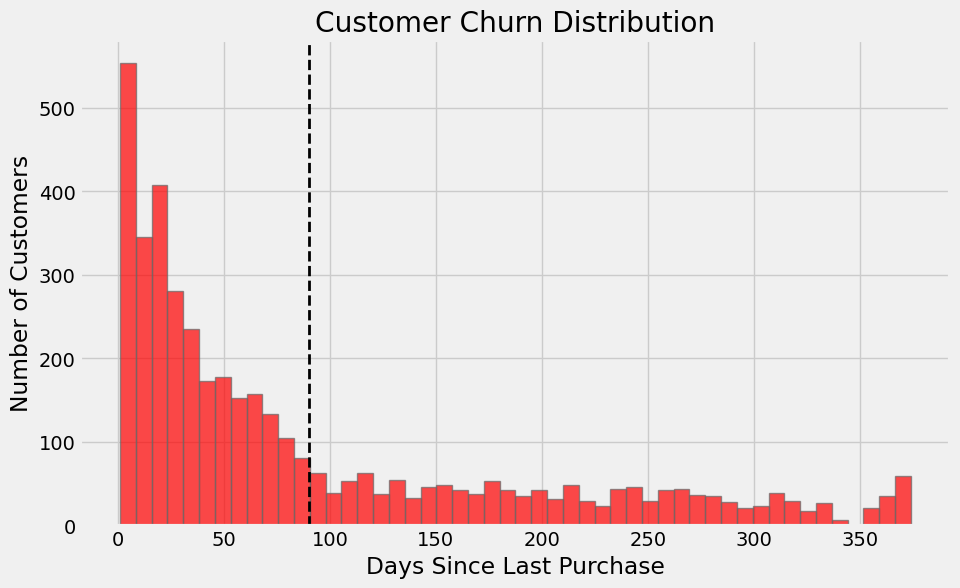

In [93]:
#lets plot 

print("Number of Churned Customers:", len(churned_customers))
plt.figure(figsize=(10, 6))
plt.hist(customer_last_purchase, bins=50, color='red', alpha=0.7)
plt.axvline(churn_threshold, color='black', linestyle='dashed', linewidth=2)
plt.title('Customer Churn Distribution')
plt.xlabel('Days Since Last Purchase')
plt.ylabel('Number of Customers')
plt.show()

In [94]:
total_number_of_customers = churned.count()
total_number_of_customers


# Number of churned customers 

np.int64(4216)

In [95]:
df3['Churned'] = df3['CustomerID'].apply(lambda x: churned.get(x, False))
df3.head()

df3[df3.Churned==True]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSales,Month,Churned
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,12,True
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,12,True
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,12,True
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,12,True
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,12,True
...,...,...,...,...,...,...,...,...,...,...,...
520736,580297,84997B,CHILDRENS CUTLERY RETROSPOT RED,72,2011-12-02 13:52:00,3.75,15769.0,United Kingdom,270.00,12,True
520737,580297,84997A,CHILDRENS CUTLERY POLKADOT GREEN,72,2011-12-02 13:52:00,3.75,15769.0,United Kingdom,270.00,12,True
540070,581458,22197,POPCORN HOLDER,1500,2011-12-08 18:45:00,0.72,17949.0,United Kingdom,1080.00,12,True
540071,581459,22197,POPCORN HOLDER,1200,2011-12-08 18:46:00,0.72,17949.0,United Kingdom,864.00,12,True


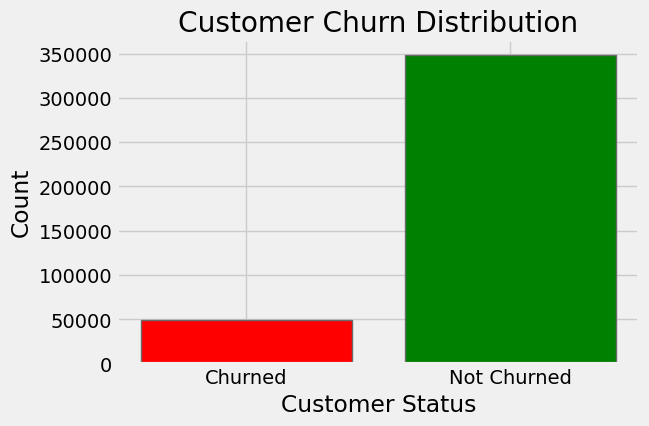

In [96]:
# Compute Churned and Not Churned counts
churn_counts = {
    "Churned": df3[df3.Churned == True].CustomerID.count(),
    "Not Churned": df3[df3.Churned == False].CustomerID.count()
}

# Plot the Churn Distribution
plt.figure(figsize=(6, 4))
plt.bar(churn_counts.keys(), churn_counts.values(), color=['red', 'green'])
plt.xlabel("Customer Status")
plt.ylabel("Count")
plt.title("Customer Churn Distribution")
plt.show()



### Customers and products

The dataframe contains `530104 entries`. What are the number of users and products in these entries?

In [97]:
df_filtered.shape

(473741, 10)

In [98]:
len(df_filtered['CustomerID'].value_counts())

4216

In [99]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 473741 entries, 0 to 541908
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    473741 non-null  string        
 1   StockCode    473741 non-null  string        
 2   Description  473741 non-null  string        
 3   Quantity     473741 non-null  int64         
 4   InvoiceDate  473741 non-null  datetime64[ns]
 5   UnitPrice    473741 non-null  float64       
 6   CustomerID   343411 non-null  float64       
 7   Country      473741 non-null  string        
 8   TotalSales   473741 non-null  float64       
 9   Month        473741 non-null  int32         
dtypes: datetime64[ns](1), float64(3), int32(1), int64(1), string(4)
memory usage: 38.0 MB


In [100]:
df_summary = pd.DataFrame({
    'products': [len(df_filtered.StockCode.value_counts())],
    'customers': [len(df_filtered.CustomerID.value_counts())],
    'transactions': [len(df_filtered.InvoiceNo.value_counts())]
}, index=['Quantity'])

print(df_summary)


          products  customers  transactions
Quantity      3870       4216         18403


* The Dataframe above shows that the data concern `4338` users and that they bought `3922` different products. 

* The total number of `transactions` carried out is of the order of  `∼19960`.

In every `transaction` a product is purchased, Let's determine the `number of products purchased` in every transaction:

In [101]:
temp_pro = df_filtered.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()

# Rename the InvoiceDate to number of products
nb_products_per_basket = temp_pro.rename(columns = {'InvoiceDate':'Number of products'})

# Sort in Ascending order based on CustomerID
nb_products_per_basket[:10].sort_values('CustomerID') # List first 10 values

,CustomerID,InvoiceNo,Number of products
0,12347.0,537626,28
1,12347.0,542237,23
2,12347.0,549222,20
3,12347.0,556201,16
4,12347.0,562032,16
5,12347.0,573511,37
6,12347.0,581180,7
7,12348.0,539318,1
8,12348.0,541998,1
9,12348.0,548955,2


In [102]:
df_filtered[df_filtered.InvoiceNo =='556201']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSales,Month
220572,556201,23084,RABBIT NIGHT LIGHT,12,2011-06-09 13:01:00,2.08,12347.0,Iceland,24.96,6
220573,556201,23162,REGENCY TEA STRAINER,8,2011-06-09 13:01:00,3.75,12347.0,Iceland,30.00,6
220574,556201,23171,REGENCY TEA PLATE GREEN,12,2011-06-09 13:01:00,1.65,12347.0,Iceland,19.80,6
220575,556201,23172,REGENCY TEA PLATE PINK,12,2011-06-09 13:01:00,1.65,12347.0,Iceland,19.80,6
220576,556201,23170,REGENCY TEA PLATE ROSES,12,2011-06-09 13:01:00,1.65,12347.0,Iceland,19.80,6
220577,556201,23173,REGENCY TEAPOT ROSES,2,2011-06-09 13:01:00,9.95,12347.0,Iceland,19.90,6
220578,556201,23174,REGENCY SUGAR BOWL GREEN,4,2011-06-09 13:01:00,4.15,12347.0,Iceland,16.60,6
220579,556201,23175,REGENCY MILK JUG PINK,4,2011-06-09 13:01:00,3.25,12347.0,Iceland,13.00,6
220580,556201,22371,AIRLINE BAG VINTAGE TOKYO 78,8,2011-06-09 13:01:00,4.25,12347.0,Iceland,34.00,6
220581,556201,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2011-06-09 13:01:00,4.25,12347.0,Iceland,17.00,6


In [103]:
list_special_codes = df_filtered[df_filtered['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
list_special_codes

<StringArray>
[        'POST',           'C2',          'DOT',            'M',
 'BANK CHARGES',    'AMAZONFEE',     'DCGS0076',     'DCGS0003',
 'gift_0001_40',     'DCGS0070',            'm', 'gift_0001_50',
 'gift_0001_30', 'gift_0001_20',     'DCGS0069',     'DCGSSBOY',
    'DCGSSGIRL', 'gift_0001_10',            'S',         'PADS',
     'DCGS0004',            'B']
Length: 22, dtype: string

In [104]:
df_filtered[df_filtered['StockCode'].isin(list_special_codes)].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSales,Month
45,536370,POST,POSTAGE,3,2010-12-01 08:45:00,18.00,12583.0,France,54.00,12
386,536403,POST,POSTAGE,1,2010-12-01 11:27:00,15.00,12791.0,Netherlands,15.00,12
1123,536527,POST,POSTAGE,1,2010-12-01 13:04:00,18.00,12662.0,Germany,18.00,12
1423,536540,C2,CARRIAGE,1,2010-12-01 14:05:00,50.00,14911.0,EIRE,50.00,12
1814,536544,DOT,DOTCOM POSTAGE,1,2010-12-01 14:32:00,569.77,NaN,United Kingdom,569.77,12


In [105]:
df_filtered[df_filtered.StockCode=="AMAZONFEE"]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSales,Month
15017,537632,AMAZONFEE,AMAZON FEE,1,2010-12-07 15:08:00,13541.33,NaN,United Kingdom,13541.33,12
135534,547901,AMAZONFEE,AMAZON FEE,1,2011-03-28 11:57:00,219.76,NaN,United Kingdom,219.76,3


In [106]:
# Pick this uniques characters from Description that corresponds to the special codes
for code in list_special_codes:
    print("{:<15} -> {:<30}".format(code, df_filtered[df_filtered['StockCode'] == code]['Description'].unique()[0]))

POST            -> POSTAGE                       
C2              -> CARRIAGE                      
DOT             -> DOTCOM POSTAGE                
M               -> Manual                        
BANK CHARGES    -> Bank Charges                  
AMAZONFEE       -> AMAZON FEE                    
DCGS0076        -> SUNJAR LED NIGHT NIGHT LIGHT  
DCGS0003        -> BOXED GLASS ASHTRAY           
gift_0001_40    -> Dotcomgiftshop Gift Voucher £40.00
DCGS0070        -> CAMOUFLAGE DOG COLLAR         
m               -> Manual                        
gift_0001_50    -> Dotcomgiftshop Gift Voucher £50.00
gift_0001_30    -> Dotcomgiftshop Gift Voucher £30.00
gift_0001_20    -> Dotcomgiftshop Gift Voucher £20.00
DCGS0069        -> OOH LA LA DOGS COLLAR         
DCGSSBOY        -> BOYS PARTY BAG                
DCGSSGIRL       -> GIRLS PARTY BAG               
gift_0001_10    -> Dotcomgiftshop Gift Voucher £10.00
S               -> SAMPLES                       
PADS            -> PADS TO MAT

We see that there are several types of `peculiar transactions`, connected e.g. to `port charges` or `bank charges`.

### Products Description

As a first step, I extract from the `Description variable` the information that will prove useful. The function below will handle this task:

In [107]:
# part-of-speech 
is_noun = lambda pos: pos[:2] == 'NN'

def keywords_inventory(dataframe, colonne = 'Description'):
    stemmer = nltk.stem.SnowballStemmer("english")  # NLTK stemmer (Snowball stemmer)
    keywords_roots  = dict()  # collect the words / root
    keywords_select = dict()  # association: root <-> keyword
    category_keys   = []
    count_keywords  = dict()
    icount = 0
    for s in dataframe[colonne]:
        if pd.isnull(s): continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)] 
        
        for t in nouns:
            t = t.lower() ; racine = stemmer.stem(t)
            if racine in keywords_roots:                
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1                
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1
                
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:  
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k ; min_length = len(k)            
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
            
            
    print("No. of keywords in variable '{}': {}".format(colonne,len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords

This function takes as `input` the dataframe and `analyzes the content` of the `Description` column by performing the following operations:

* extract the names (proper, common) appearing in the products description

* for each name, I extract the root of the word and aggregate the set of names associated with this particular root

* count the number of times each root appears in the dataframe

* when several words are listed for the same root, I consider that the keyword associated with this root is the shortest name (this systematically selects the singular when there are singular/plural variants)


The first step of the `analysis` is to retrieve the list of products:

In [108]:
df_products = pd.DataFrame(df_filtered['Description'].unique()).rename(columns = {0:'Description'})
df_products

,Description
0,WHITE HANGING HEART T-LIGHT HOLDER
1,WHITE METAL LANTERN
2,CREAM CUPID HEARTS COAT HANGER
3,KNITTED UNION FLAG HOT WATER BOTTLE
4,RED WOOLLY HOTTIE WHITE HEART.
...,...
3954,SET OF 6 RIBBONS PARTY
3955,SET 10 CARDS SNOWY ROBIN 17099
3956,SET 10 CARDS SWIRLY XMAS TREE 17104
3957,"LETTER ""U"" BLING KEY RING"


Once this list is created, Will have to use the function I previously defined in order to analyze the `description` of the various products:

In [109]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\kiru\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [110]:
keywords, keywords_roots, keywords_select, count_keywords = keywords_inventory(df_products)

No. of keywords in variable 'Description': 1516


The execution of this function returns three variables:

* `keywords:` the list of extracted keywords

* `keywords_roots:` a dictionary where the keys are the keywords roots and the values are the lists of words associated with those roots

* `count_keywords:` dictionary listing the number of times every word is used

At this point, I'll convert the `count_keywords` dictionary into a list, to sort the `keywords` according to their occurences:

In [111]:
list_products = []
for k,v in count_keywords.items():
    list_products.append([keywords_select[k],v])
list_products.sort(key = lambda x:x[1], reverse = True)

Using it, I'll create a `representation` of the `most common keywords`:

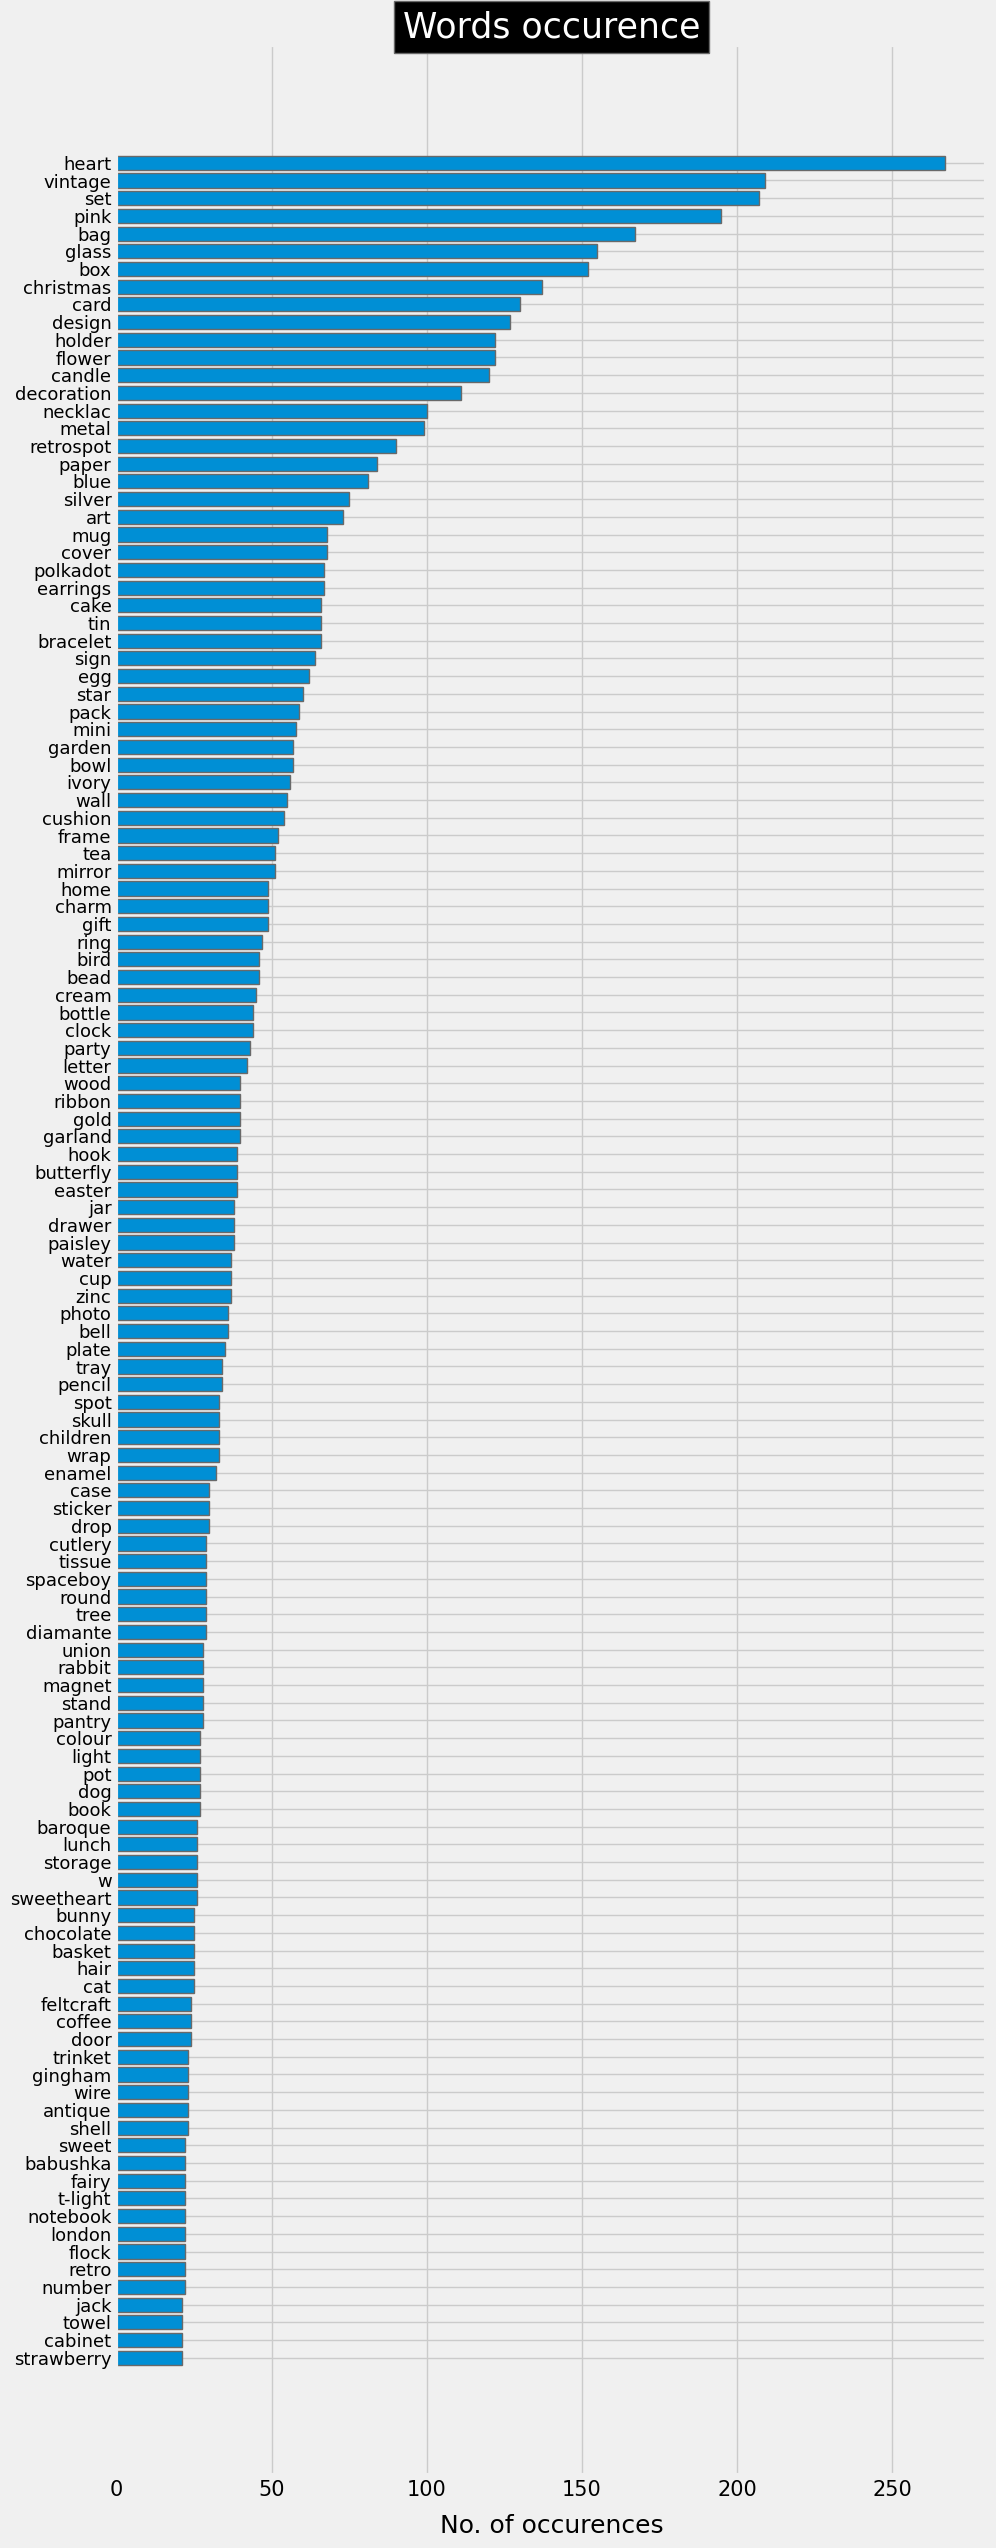

In [112]:
liste = sorted(list_products, key = lambda x:x[1], reverse = True)


plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(10, 30))
y_axis = [i[1] for i in liste[:125]]
x_axis = [k for k,i in enumerate(liste[:125])]
x_label = [i[0] for i in liste[:125]]
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 13)
plt.yticks(x_axis, x_label)
plt.xlabel("No. of occurences", fontsize = 18, labelpad = 10)
ax.barh(x_axis, y_axis, align = 'center')
ax = plt.gca()
ax.invert_yaxis()


plt.title("Words occurence",bbox={'facecolor':'k', 'pad':5}, color='w',fontsize = 25)
plt.show()

In [149]:
def top_n_spender(df_filtered,n=5):
    """
    find the top N highest spending customers"
    
    parameters:"
    -df_filetered(dateframe): the customer transaction data.
    -n(init): number of top customer to return 

    Returns:
    -df_filtered: dataframe with the top N highest spending customers.
    """

    # Group by CustomerID and sum the TotalSales
    top_spender = df_filtered.sort_values(by='TotalSales', ascending=False).head(n)

    valid_spenders = []

    for _, row in top_spender.iterrows():
        if not pd.isna(row['CustomerID']):  # Skip rows with NaN CustomerID
            valid_spenders.append(row)
        if len(valid_spenders) == n:  # Stop when we have N valid customers
            break

    # Convert list to DataFrame
    top_spenders_df = pd.DataFrame(valid_spenders)
    

    print(f"top {n} highest spending customers:")
    print(top_spender[['CustomerID', 'TotalSales']])

    return top_spender[['CustomerID', 'TotalSales']]

top_spender = top_n_spender(df_filtered,n=3)

valid_spenders = top_spender['CustomerID'].dropna().unique()

top 3 highest spending customers:
        CustomerID  TotalSales
15017          NaN    13541.33
299982         NaN    11062.06
173382     16029.0     8142.75


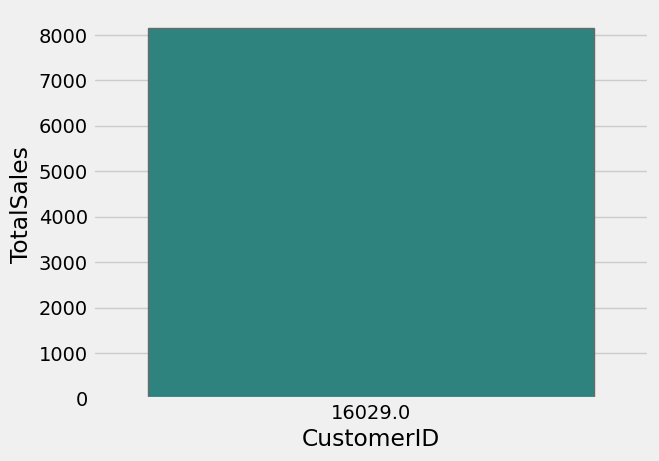

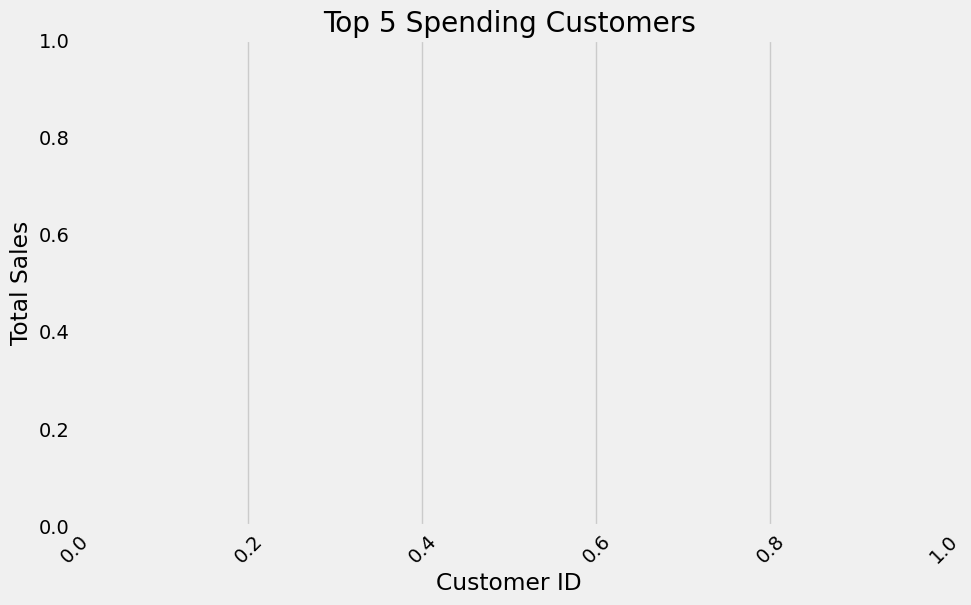

In [140]:
def plot_top_spender(top_spender):
    
    sns.barplot(x=top_spender['CustomerID'], y=top_spender['TotalSales'], palette='viridis')
    plt.figure(figsize=(10, 6))
    plt.title('Top 5 Spending Customers')
    plt.xlabel('Customer ID')
    plt.ylabel('Total Sales')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.show()

plot_top_spender(top_spender)